# Daten kombinieren

**Inhalt:** Verschiedene Quellen kombinieren, optisch und tabellarisch auswerten

**Nötige Skills:** Daten explorieren, filtern, klassifizieren

**Lernziele:**
- Besser verstehen, wie Merge funktioniert
- Daten kombinieren, Hypothesen testen
- Einführung in Geopandas

# Das Beispiel

Der Immobilienboom hat die Schweiz über die letzten Jahre stark geprägt.

Dazu haben wir Daten aus verschiedenen Quellen, die wir kombinieren möchten:
- Bevölkerungsdaten aus Schweizer Gemeinden (BFS)
- Wohnungsbau in Schweizer Gemeinden (BFS)
- Leerwohnungsziffer in Schweizer Gemeinden (BFS)

Anhand dieser Daten wollen wir herausfinden:
- Welche Gemeinden sind am meisten gewachsen? Wo wurde am stärksten am Markt vorbeigebaut?

Und natürlich wollen wir unsere Resultate schön darstellen.

## Vorbereitung

Wir importieren ausnahmsweise etwas mehr Bibliotheken als sonst...

In [1]:
import pandas as pd

In [2]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [3]:
from shapely.geometry import Point

In [4]:
import matplotlib

In [5]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

## Daten laden

### Einwohnerzahlen

Wir starten mit einem File, das die Einwohnerzahl der Schweizer Gemeinden beinhaltet, für alle Jahre von 1981 bis 2016.

In [8]:
df_bev = pd.read_excel('dataprojects/immobilienboom/data/BFS Gemeinden Einwohnerzahlen.xlsx')

Check: Wie viele Gemeinden sind enthalten?

In [9]:
df_bev.shape

(2282, 38)

In [10]:
df_bev.head(2)

,Gemeindenummer,Gemeindename,1981,1982,1983,1984,1985,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,261,Zürich,370103,366040,363449,356665,354525,351545,349549,346879,...,350125,358540,365132,368677,372857,376990,380777,384786,391359,396955
1,6621,Genève,156617,157322,158426,158806,159527,159895,160645,161473,...,178603,179971,183287,185958,187470,188234,189033,191557,194565,198072


**Tipp:** Um sämtliche Spalten anzuzeigen, können wir bei Pandas die Display-Option anders einstellen:

In [11]:
pd.set_option("display.max_columns", 50) #wenn man alle Spalten sehen möchte (bzw. wie hier 50)

In [12]:
df_bev.head(2)

,Gemeindenummer,Gemeindename,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,261,Zürich,370103,366040,363449,356665,354525,351545,349549,346879,345159,342861,341934,343267,345235,343045,342872,343869,341250,338594,336821,336822,337035,340197,342116,342853,345236,347517,350125,358540,365132,368677,372857,376990,380777,384786,391359,396955
1,6621,Genève,156617,157322,158426,158806,159527,159895,160645,161473,163998,165404,168530,169025,170189,171744,172737,173549,172425,172586,172809,173519,174691,175697,177306,178500,178487,178722,178603,179971,183287,185958,187470,188234,189033,191557,194565,198072


### Wohnungszahlen

Wir haben drei Files für die Anzahl der Wohnungen:

- **eines für die totale Anzahl Wohnungen pro Gemeinde, von 2009 bis 2016**

In [13]:
df_wohn_tot = pd.read_excel('dataprojects/immobilienboom/data//BFS Anzahl Wohnungen Total.xlsx')

**Check:** Wie viele Gemeinden sind im File?

In [14]:
df_wohn_tot.shape

(2287, 10)

In [15]:
df_wohn_tot.head(3)

,Gemeindenummer,Gemeindename,2009,2010,2011,2012,2013,2014,2015,2016
0,1,Aeugst am Albis,689,856,856,870,875,876,887,891
1,2,Affoltern am Albis,4904,5170,5201,5286,5427,5477,5527,5614
2,3,Bonstetten,2242,2289,2303,2302,2320,2354,2383,2428


- **eines für die Wohnungen in Einfamilienhäusern**

In [16]:
df_wohn_efh = pd.read_excel('dataprojects/immobilienboom/data/BFS Anzahl Wohnungen EFH.xlsx')

In [17]:
df_wohn_efh.head(2)

,Gemeindenummer,Gemeindename,2009,2010,2011,2012,2013,2014,2015,2016
0,1,Aeugst am Albis,314,384,384,388,381,380,381,380
1,2,Affoltern am Albis,1077,1085,1087,1090,1086,1087,1082,1081


- **eines für die Anzahl der Wohnungen in Mehrfamilienhäuser**

In [18]:
df_wohn_mfh = pd.read_excel('dataprojects/immobilienboom/data/BFS Anzahl Wohnungen MFH.xlsx')

In [19]:
df_wohn_mfh.head(2)

,Gemeindenummer,Gemeindename,2009,2010,2011,2012,2013,2014,2015,2016
0,1,Aeugst am Albis,280,372,374,381,387,391,401,402
1,2,Affoltern am Albis,2959,3051,3068,3173,3327,3365,3428,3453


### Leerwohnungsziffern

Schliesslich haben wir eine Datei, welche die aktuelle Leerwohnungsziffer für jede Gemeinde beinhaltet.

In [20]:
df_lwz = pd.read_excel('dataprojects/immobilienboom/data/BFS Leerwohnungsziffer 2017.xlsx')

**Check:** Wie viele Gemeinden sind drin? (Hint: nicht genau gleich viele wie im anderen File...)

In [21]:
df_lwz.shape

(2240, 3)

In [23]:
df_lwz.head(2)

,Gemeindenummer,Gemeinde,Leerwohnungsziffer
0,1,Aeugst am Albis,2.581369
1,2,Affoltern am Albis,1.229070


## Analyse

Wir möchten nun die drei (fünf) Tabellen gemeinsam auswerten, und zwar im Hinblick auf Fragen wie:
- Was sind Gemeinden, die einen starken Bauboom hatten und nun eine hohe Leerwohnungsziffer aufweisen?
- Haben die Leerstände etwas mit der Gemeindegrösse zu tun, gibt es in Städten höhere/tiefere Ziffern als in Dörfern?

Um Fragen dieser Art zu beantworten, müssen wir uns zwei Dinge überlegen:
1. Was sind geeignete Indikatoren, die wir konkret bilden wollen, um unsere Fragen zu beantworten?
2. Wie bringen wir die verschiedenen Indikatoren zusammen, um sie gemeinsam auszuwerten?

Wir starten mal mit der ersten Überlegung...

### Indikatoren bilden

Wir wählen zu Analysezwecken drei Indikatoren aus:
- das Bevölkerungswachstum zwischen 1996 und 2016, in Prozent
- das Wohnungswachstum (total) zwischen 2009 und 2016, in Prozent
- die Leerwohungsziffer 2017, in Prozent

Zwei der drei Indikatoren müssen wir erst noch bilden.

In [31]:
df_bev['Bevölkerungswachstum'] = (df_bev['2016'] / df_bev['1996'] - 1) * 100

In [32]:
df_bev.head(2)

,Gemeindenummer,Gemeindename,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Bevölkerungswachstum
0,261,Zürich,370103,366040,363449,356665,354525,351545,349549,346879,345159,342861,341934,343267,345235,343045,342872,343869,341250,338594,336821,336822,337035,340197,342116,342853,345236,347517,350125,358540,365132,368677,372857,376990,380777,384786,391359,396955,15.437856
1,6621,Genève,156617,157322,158426,158806,159527,159895,160645,161473,163998,165404,168530,169025,170189,171744,172737,173549,172425,172586,172809,173519,174691,175697,177306,178500,178487,178722,178603,179971,183287,185958,187470,188234,189033,191557,194565,198072,14.130303


In [26]:
df_wohn_tot['Wohnungswachstum Total'] = (df_wohn_tot['2016'] / df_wohn_tot['2009'] - 1) * 100

In [27]:
df_wohn_tot.head(2)

,Gemeindenummer,Gemeindename,2009,2010,2011,2012,2013,2014,2015,2016,Wohnungswachstum Total
0,1,Aeugst am Albis,689,856,856,870,875,876,887,891,29.317852
1,2,Affoltern am Albis,4904,5170,5201,5286,5427,5477,5527,5614,14.477977


### Tabellen zusammenführen

Nun müssen wir die drei Indikatoren in einer Tablle zusammenbringen. Wir benutzen dazu die Funktion `merge()`:

**1. zunächst schliessen wir die Wohnungszahlen mit den Bevölkerungszahlen zusammen:**

In [34]:
df_1 = df_bev.merge(df_wohn_tot, how='inner', on='Gemeindenummer')
df_1.head(2)

,Gemeindenummer,Gemeindename_x,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009_x,2010_x,2011_x,2012_x,2013_x,2014_x,2015_x,2016_x,Bevölkerungswachstum,Gemeindename_y,2009_y,2010_y,2011_y,2012_y,2013_y,2014_y,2015_y,2016_y,Wohnungswachstum Total
0,261,Zürich,370103,366040,363449,356665,354525,351545,349549,346879,345159,342861,341934,343267,345235,343045,342872,343869,341250,338594,336821,336822,337035,340197,342116,342853,345236,347517,350125,358540,365132,368677,372857,376990,380777,384786,391359,396955,15.437856,Zürich,207183,208090,209701,211942,214470,215608,218586,220940,6.640024
1,6621,Genève,156617,157322,158426,158806,159527,159895,160645,161473,163998,165404,168530,169025,170189,171744,172737,173549,172425,172586,172809,173519,174691,175697,177306,178500,178487,178722,178603,179971,183287,185958,187470,188234,189033,191557,194565,198072,14.130303,Genève,101701,104440,104760,105217,106075,106313,107056,107474,5.676444


Pandas hat nun anhand der Gemeindenummer (einem unique identifier) die beiden Dataframes fusioniert.

**Frage:** Wie viele Gemeinden sind im neuen Dataframe enthalten? Woher kommt diese Zahl? 

Und: Wie viele Gemeinden wären enthalten, wenn wir `how='outer'` gewählt hätten? Warum?

In [35]:
#Antwort
df_1.shape

(2282, 49)

In [36]:
df_bev.merge(df_wohn_tot, how='outer', on='Gemeindenummer').shape

(2287, 49)

**Quiz:** Finden Sie die fünf Gemeinden, die in der Bevölkerungszahlen-Tabelle nicht enthalten sind.

In [37]:
#Antwort
df_test = df_bev.merge(df_wohn_tot, how='outer', on='Gemeindenummer')
df_test[df_test['1981'].isnull()]

,Gemeindenummer,Gemeindename_x,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009_x,2010_x,2011_x,2012_x,2013_x,2014_x,2015_x,2016_x,Bevölkerungswachstum,Gemeindename_y,2009_y,2010_y,2011_y,2012_y,2013_y,2014_y,2015_y,2016_y,Wohnungswachstum Total
2282,4546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schlatt (TG),686,696,703,712,727,738,767,781,13.848397
2283,4683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lengwil,582,593,596,601,635,670,704,717,23.195876
2284,4723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Braunau,277,284,292,294,303,314,319,321,15.884477
2285,4724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Eschlikon,1688,1703,1742,1837,1894,1898,1927,1938,14.810427
2286,4786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wilen (TG),830,826,831,848,895,943,972,1003,20.843373


**2. Nun nehmen wir noch die Leerwohnungsziffer dazu** 

In [39]:
df_2 = df_1.merge(df_lwz, how='inner', on='Gemeindenummer')

In [40]:
df_2.head(2)

,Gemeindenummer,Gemeindename_x,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009_x,2010_x,2011_x,2012_x,2013_x,2014_x,2015_x,2016_x,Bevölkerungswachstum,Gemeindename_y,2009_y,2010_y,2011_y,2012_y,2013_y,2014_y,2015_y,2016_y,Wohnungswachstum Total,Gemeinde,Leerwohnungsziffer
0,261,Zürich,370103,366040,363449,356665,354525,351545,349549,346879,345159,342861,341934,343267,345235,343045,342872,343869,341250,338594,336821,336822,337035,340197,342116,...,345236,347517,350125,358540,365132,368677,372857,376990,380777,384786,391359,396955,15.437856,Zürich,207183,208090,209701,211942,214470,215608,218586,220940,6.640024,Zürich,0.205486
1,6621,Genève,156617,157322,158426,158806,159527,159895,160645,161473,163998,165404,168530,169025,170189,171744,172737,173549,172425,172586,172809,173519,174691,175697,177306,...,178487,178722,178603,179971,183287,185958,187470,188234,189033,191557,194565,198072,14.130303,Genève,101701,104440,104760,105217,106075,106313,107056,107474,5.676444,Genève,0.573162


**Tipp:** Es lohnt sich, bei merge-Operationen ein neues Dataframe zu erstellen, sonst gibt es schnell mal ein Chaos.

Weil wir an den meisten Infos in diese Tabelle gar nicht interessiert sind, selektieren wir etwas, auch der Übersichtlichkeit halber.

Wir wählen nur unsere drei Indikatoren sowie den aktuellen Bevölkerungsstand.

In [42]:
df_3 = df_2[['Gemeindenummer', 'Gemeinde', '2016_x', 'Bevölkerungswachstum', 'Wohnungswachstum Total', 'Leerwohnungsziffer']].copy()
df_3.rename(columns={'2016_x': 'Bevölkerung'}, inplace=True)
df_3.head(2)

,Gemeindenummer,Gemeinde,Bevölkerung,Bevölkerungswachstum,Wohnungswachstum Total,Leerwohnungsziffer
0,261,Zürich,396955,15.437856,6.640024,0.205486
1,6621,Genève,198072,14.130303,5.676444,0.573162


Wir sind nun bereit für eine erste Analyse - am einfachsten mit ein paar Scatterplots, da sieht man schnell mal, ob etwas zusammenhängt.

### Charts

**Frage:** Wie hängen Wohnungswachstum und Leerwohnungsziffer zusammen?

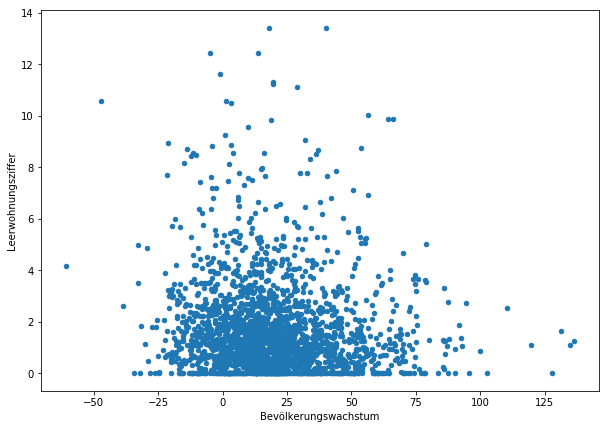

In [43]:
df_3.plot(kind='scatter', x='Bevölkerungswachstum', y='Leerwohnungsziffer', figsize=(10,7))

Antwort: In einigen Gemeinden ist die Bevölkerung sehr stark gewachsen, dort sind die Leerstände allerdings nicht so gross. Tendenziell am meisten Leerstände gibt es in der Mitte der Verteilung. Schrumpfende Gemeinden haben meist nicht ganz so hohe Leerstände.

Wir können den Plot übrigens noch etwas aufhübschen und die Punkte nach Bevölkerungsgrösse skalieren...

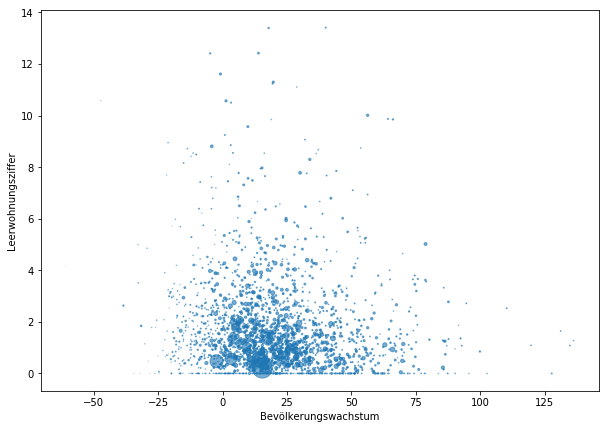

In [44]:
area = df_3['Bevölkerung'] / 1000
df_3.plot(kind='scatter', x='Bevölkerungswachstum', y='Leerwohnungsziffer', s=area, alpha=0.6, figsize=(10,7))

**Quiz:** Wie hängt das Wohnungswachstum mit dem Bevölkerungswachstum zusammen? Zeichnen Sie einen Plot.

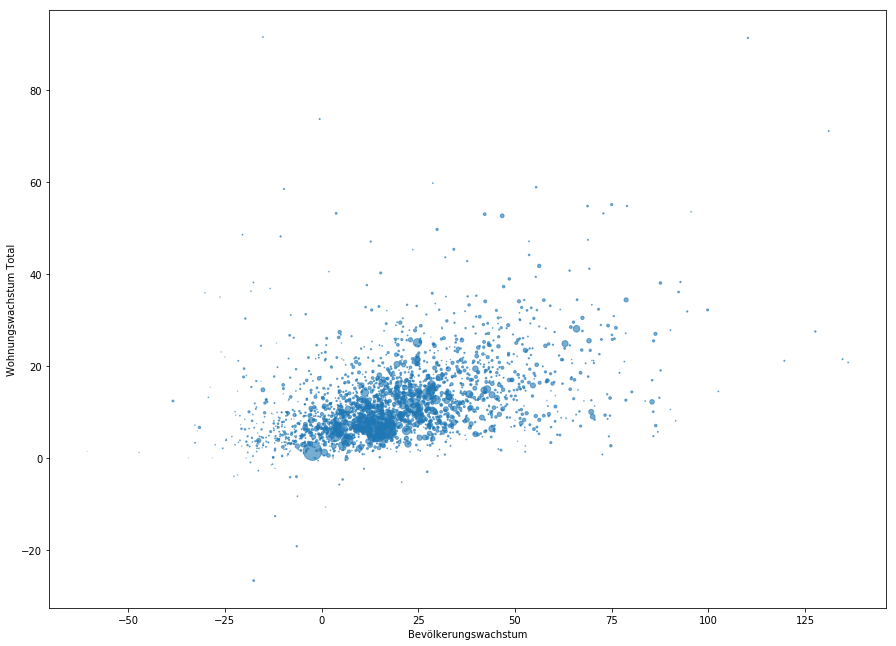

In [53]:
#Antwort
area = df_3['Bevölkerung'] / 500
df_3.plot(kind='scatter', x='Bevölkerungswachstum', y='Wohnungswachstum Total', s=area, alpha=0.6, figsize=(15,11))


**Quiz:** Bilden Sie eine neue Kennzahl, die das Wohnungswachstum mit dem Bevölkerungswachstum vergleicht.

Wie verhält sich diese Kennzal zur Leerwohnungsziffer?

In [54]:
#Antwort
df_3['Wohn-Bev-Ratio'] = df_3['Wohnungswachstum Total'] / df_3['Bevölkerungswachstum']

In [ ]:
area = df_3

Offensichtlich bringen uns diese Charts auch nicht viel weiter. Wir wissen jetzt zwar, dass die grossen Städte kein besonders hohes Wachstum verzeichneten und auch nicht sehr hohe Leerstände aufweisen, aber nicht viel mehr.

Da hilft nur ein: Geopandas, to the rescue!

## Geo Plots

Geopandas funktioniert sehr ähnlich wie Pandas - bietet aber zusätzliche Funktionalität!

Zuerst müssen wir ein paar Geodaten laden, so genannte shape files.

### Geodaten laden

Zuerst eines für die Schweizer Landesgrenzen...

In [ ]:
gdf_ch = gpd.read_file('dataprojects/immobilienboom/shp/g1l17.shp')
gdf_ch.head(2)

... dann eines für die Gemeinden...

In [ ]:
gdf_gemeinden = gpd.read_file('dataprojects/immobilienboom/shp/g1g17.shp')
gdf_gemeinden.head(2)

... und noch eines für die Seen!

In [ ]:
gdf_lakes = gpd.read_file('dataprojects/immobilienboom/shp/g1s17.shp')
gdf_lakes.head(2)

Das coole an Geopandas ist: Man kann diese Shapefiles mit wenigen Zeilen Code zeichnen lassen.

In [ ]:
ax = gdf_ch.plot(edgecolor='grey', color='white', alpha=1, linewidth=2, figsize=(20,13))
gdf_lakes.plot(edgecolor='grey', facecolor='lightblue', alpha=1, linewidth=1, ax=ax)
gdf_gemeinden.plot(edgecolor='grey', color='white', alpha=1, linewidth=0.2, ax=ax)
ax.axis('off')

Das hier brauchen wir später noch:

In [ ]:
title_font = {
    'family': 'sans-serif',
    'color':  'black',
    'weight': 'bold',
    'size': 20
}
point_names = {
    'family': 'sans-serif',
    'color':  'black',
    'weight': 'normal',
    'size': 10
}

### Geodaten mit den restlichen Infos verbinden

Damit wir auf der Karte nicht nur die Gemeinden einzeichnen können, sondern auch die restlichen Infos (zB die Leerwohnungsziffer), müssen wir erneut zwei Tabellen verschmelzen. Merke: In der Geodaten-Tabelle heisst das dazugehörige Index-Feld für die Gemeinenummer nicht "Gemeindenummer", sondern "GMDNR".

In [ ]:
gdf_gemeinden_m = gdf_gemeinden.merge(df_3, how="inner", left_on="GMDNR", right_on="Gemeindenummer")

In [ ]:
gdf_gemeinden_m.head(2)

### Choropleth Maps

Machen wir mal einen ersten Plot, um zu schauen, welche Gemeinden einwohnermässig am meisten gewachsen sind.

In [ ]:
#Selber Code wie oben, für die Landesgrenzen und die Seen
ax = gdf_ch.plot(edgecolor='grey', color='white', alpha=1, linewidth=2, figsize=(20,13))
gdf_lakes.plot(edgecolor='grey', facecolor='lightblue', alpha=1, linewidth=1, ax=ax)

#Code für die Gemeinden, eingefärbt nach der Spalte "Bevölkerungswachstum"
gdf_gemeinden_m.plot(edgecolor='grey', column='Bevölkerungswachstum', cmap='YlOrRd', scheme='quantiles', alpha=0.8, linewidth=0.5, ax=ax, legend=True)

my_title = "Bevölkerungswachstum in den Gemeinden zwischen 2009 und 2016"
plt.text(480000, 312000, my_title, fontdict=title_font)

ax.axis('off')

### Dot Maps

Ich persönlich mag choropleth maps nicht so - viel lieber dot maps.

Dazu müssen wir kurz die Geometrie unseres Geodataframes ändern (was das genau ist, wird später im Kurs noch behandelt)

In [ ]:
gdf_gemeinden_m['point_geometry'] = gdf_gemeinden_m.apply(lambda row: Point(row.X_CNTR, row.Y_CNTR), axis=1)

In [ ]:
gdf_gemeinden_m = gdf_gemeinden_m.set_geometry('point_geometry')

Plus, wir kreieren uns noch eine zusätzliche Spalte mit dem marker size:

In [ ]:
#play around with the marker size
gdf_gemeinden_m['markersize'] = (gdf_gemeinden_m['Bevölkerung'] ** 0.5) / 1.5

Jetzt sind wir ready für diesen Plot-Typ

In [ ]:
#Selber Code wie oben, für die Landesgrenzen und die Seen
ax = gdf_ch.plot(edgecolor='grey', color='#EEEEEE', alpha=1, linewidth=2, figsize=(20,13))
gdf_lakes.plot(edgecolor='grey', facecolor='lightblue', alpha=1, linewidth=1, ax=ax)

#Wir haben die Gemetrie zuvor auf einen Punkt gesetzt - darum kommt das jetzt etwas anders raus
gdf_gemeinden_m.plot(markersize=gdf_gemeinden_m['markersize'], column='Bevölkerungswachstum', cmap='YlOrRd', scheme='quantiles', alpha=0.7, linewidth=0.5, legend=True, ax=ax)

my_title = "Bevölkerungswachstum in den Gemeinden zwischen 2009 und 2016"
plt.text(480000, 312000, my_title, fontdict=title_font)

ax.axis('off')

Das schöne ist: Man sieht jetzt, wo die Gemeinden wirklich sind, und vor allem auch: wie gross sie sind.

Es zeigt sich: Stark gewachsen ist die Bevölkerung vor allem um den Genfersee sowie im Raum Zug-Zürich.

Machen wir gleich noch einen Plot - mit den **Leerstandsziffern**

In [ ]:
#Selber Code wie oben, für die Landesgrenzen und die Seen
ax = gdf_ch.plot(edgecolor='grey', color='#EEEEEE', alpha=1, linewidth=2, figsize=(20,13))
gdf_lakes.plot(edgecolor='grey', facecolor='lightblue', alpha=1, linewidth=1, ax=ax)

#Die Gemeinden, eingefärbt anhand der Leerwohnungsziffer
gdf_gemeinden_m.plot(markersize=gdf_gemeinden_m['markersize'], column='Leerwohnungsziffer', cmap='YlOrRd', scheme='quantiles', alpha=0.8, linewidth=0.5, legend=True, ax=ax)

my_title = "Leerwohnungsziffer 2017"
plt.text(480000, 312000, my_title, fontdict=title_font)

ax.axis('off')

Man sieht nun sehr rasch, wo die Problemzonen sind: im Mittelland, im Wallis, um den Bodensee.

Die Frage ist: Können wir die "schlimmsten" Gemeinden irgendwie identifizieren?

## Gemeinden filtern

Wir gehen jetzt einfach mal explorativ vor - und selektieren eine Reihe von Gemeinden anhand von bestimmten Kriterien, die wir als problematisch oder einfach nur als interessant erachten im Kontext des Immobilien-Baubooms der letzten Jahre.

Zum Beispiel:
- hohes Wohnungswachstum (>20%)
- hohe Leerstandsziffer (>4%)
- minimale Grösse (>500 Einwohner)

Was sind das für Gemeinden?

In [ ]:
gdf_gemeinden_1 = gdf_gemeinden_m[(gdf_gemeinden_m['Leerwohnungsziffer'] >= 4) & (gdf_gemeinden_m['Wohnungswachstum Total'] > 20) & (gdf_gemeinden_m['Bevölkerung'] > 500)]


In [ ]:
gdf_gemeinden_1.sort_values('Wohnungswachstum Total', ascending=False)[['Gemeinde', 'Bevölkerung', 'Wohnungswachstum Total', 'Leerwohnungsziffer']]


Und wo sind sie?

In [ ]:
#Selber Code wie oben, für die Landesgrenzen und die Seen
ax = gdf_ch.plot(edgecolor='grey', color='#EEEEEE', alpha=1, linewidth=2, figsize=(20,13))
gdf_lakes.plot(edgecolor='grey', facecolor='lightblue', alpha=1, linewidth=1, ax=ax)

#Die Gemeinden, eingefärbt anhand der Leerwohnungsziffer (Achtung, neue, angepasste Farbskala!)
gdf_gemeinden_1.plot(markersize=gdf_gemeinden_1['markersize'], column='Leerwohnungsziffer', cmap='YlOrRd', scheme='quantiles', alpha=0.8, linewidth=0.5, legend=True, ax=ax)

#Wir schreiben die Punkte noch an :-)
for i in gdf_gemeinden_1.index:
    y = gdf_gemeinden_1.loc[i, 'Y_CNTR']
    x = gdf_gemeinden_1.loc[i, 'X_MAX']
    gemeindename = gdf_gemeinden_1.loc[i, 'Gemeinde']
    plt.text(x, y, gemeindename, fontdict=point_names)

my_title = "Gemeinden mit hohen Leerständen und grossem Bauboom"
plt.text(480000, 312000, my_title, fontdict=title_font)

ax.axis('off')

Falls wir mal eine Reportage aus einer Gemeinde machen wollen, in der viel gebaut wurde - am Markt vorbei - wären das hier die Kandidaten!

## Und nun, zum selber machen...

Welches sind Gemeinden, die man sich näher anschauen sollte?
1. Wählen Wie Indikatoren aus, der Sie interessiert (zB: Einfamilienhäuser, Leerstände)
1. Verbinden Sie die Datensets
1. Geodaten und restliche Daten verbinden
1. Filtern Sie eine Reihe von Gemeinden heraus, die speziell auffallen
1. Plotten Sie diese Gemeinden auf einer Karte

Keine Angst: Geopandas-Funktionen kommen erst im letzten Schritt rein.

### 1. Indikatoren wählen

Gehen Sie nochmals ganz nach oben zurück, zum Teil "Analyse".

Und berechnen Sie eine Reihe von Indikatoren, die Sie näher untersuchen wollen, aus den Tabellen "df_bev", "df_wohn_tot", "df_wohn_EFH", "df_wohn_MFH", "df_lwz". (Oder wenn Sie ganz verwegen sind: Holen Sie sich vom www.bfs.admin.ch irgendeine andere Statistik auf Gemeindeebene, welche die Gemeindenummer beinhaltet!)

### 2. Tabellen zusammenführen

Benutzen Sie die Funktion `merge()`, um ihre Zahlen in einer einzigen Tabelle zu verschmelzen!

### 3. Geodaten mit Tabellen verbinden
Holen Sie sich nochmals das originale Geodataframe "gdf_gemeinden". Führen Sie dieses zusammen mit ihrer Tabelle.

### 4. Gemeinden filtern
Spielen Sie mit den Parametern so lange, bis Sie eine Liste von ungefähr 30 Gemeinden erhalten, die alle ihre Kriterien erfüllen.

### 5. Dot Map der gefilterten Gemeinden
Die hohe Kunst des Programmierens ist: Code kopieren, Code anpassen. Nicht vergessen: Punkt-Geometrie im Geodataframe nochmals setzen!